In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mia-hw-3/submission.csv
/kaggle/input/mia-hw-3/train.csv
/kaggle/input/mia-hw-3/test.csv
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img1.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img10.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img14.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img6.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img16.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img12.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img17.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img15.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img3.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img8.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img5.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img21.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img2.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img7.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img11.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img18.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img4.dcm
/kaggle/input/mia-hw-3/DICOM/0416567/T1/img20.dcm
/kagg

In [2]:
!pip install pydicom
!pip install torchsummary

In [3]:
import warnings
import gc
import os
import random

from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import pydicom
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import models, transforms
from torchvision.transforms import v2
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

warnings.filterwarnings('ignore')

In [4]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [5]:
root = "/kaggle/input/mia-hw-3"

train_data = pd.read_csv(os.path.join(root, "train.csv"))
print(f"Numbers of train data : {len(train_data)}")
train_data.head(10)

Numbers of train data : 80


ID  Disease
0   545876        0
1   517509        0
2     4194        0
3     8098        0
4   230450        0
5   193329        0
6   889904        0
7  1126761        1
8   310883        0
9   347447        0

In [6]:
train_data_label_dist = pd.DataFrame(
    {
        "label" : train_data.iloc[:, 1].value_counts().sort_index().index.astype(str),
        "counts" : train_data.iloc[:, 1].value_counts().sort_index().values
    }
)
train_data_label_dist

label  counts
0     0      40
1     1      40

In [7]:
# image interpolation
class Interpolate():
    
    def __init__(self, target_num = 22):
        self.target_num = target_num
    
    def __call__(self, slices): # (3, XX, 512, 512) 其中 XX 是切片的數量
        slices = slices.unsqueeze(dim = 0) # (1, 3, XX, 512, 512)
        slices = F.interpolate(
                  slices, 
                  mode = 'trilinear',
                  size = (self.target_num, slices.shape[-2], slices.shape[-1])) # (1, 3, target_num, 512, 512) 其中 slices.shape[-2], slices.shape[-1]為 XX 張 slice 的 H, W
        return torch.transpose(slices.squeeze(), 0, 1) # slices.squeeze()的形狀為 (3, 22, 512, 512)， 經過 transpose 後形狀變為 (22, 3, 512, 512)

In [8]:
def build_transform(is_train):
    t = []
    if is_train:       
        t.append(Interpolate(target_num=22))
        t.append(transforms.RandomRotation(5))  # 隨機旋轉
        t.append(transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)))  # 隨機平移
        t.append(transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)))
        return v2.Compose(t)

    t.append(Interpolate(target_num=22))
    return v2.Compose(t)

In [9]:
def evaluator(preds, gts):
    preds = preds.cpu().detach().numpy() 
    gts = gts.cpu().numpy() 
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average="macro")

    return acc, f1

In [10]:
def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    train_loss = .0
    predictions, ground_truths = [], []

    for images, labels in train_loader:
        
        images = [image.to(device=device, dtype=torch.float) for image in images]
        labels = labels.to(device=device, dtype=torch.long)

       
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        
        scheduler.step()

        
        train_loss += loss.item()
        
        preds = torch.argmax(logits, dim=1)

        predictions.append(preds)
        ground_truths.append(labels)

    
    train_loss /= len(train_loader)

    
    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    
    train_acc, train_f1 = evaluator(predictions, ground_truths)

    return train_loss, 100 * train_acc, 100 * train_f1

In [11]:
def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images = [image.to(device=device, dtype=torch.float) for image in images]
            labels = labels.to(device=device, dtype=torch.long)

            logits = model(images)
            loss = criterion(logits, labels)

            valid_loss += loss.item()
            preds = torch.argmax(logits, dim=1)

            predictions.append(preds)
            ground_truths.append(labels)

        valid_loss /= len(valid_loader)

        predictions = torch.cat(predictions)
        ground_truths = torch.cat(ground_truths)
        valid_acc, valid_f1 = evaluator(predictions, ground_truths)
    return valid_loss, 100*valid_acc, 100*valid_f1

In [12]:
def testing(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for images in test_loader:
            
            images = [image.to(device=device, dtype=torch.float) for image in images]
            logits = model(images)
            pred = torch.argmax(logits, dim=1)

            preds.append(pred)


    preds = torch.cat(preds)

    return preds

In [13]:
class MRI2DDataset(Dataset):
    def __init__(self, df, mode = None, transforms = None):
        
        root = "/kaggle/input/mia-hw-3"
        self.ids = np.array(df["ID"])
        self.labels = torch.from_numpy(np.array(df["Disease"]))
        self.mode = mode
        self.transforms = transforms
        
        paths = []
        for ID in np.array(df["ID"]):
            path = os.path.join(root, "DICOM", str(ID).split('.')[0].zfill(7))
            paths.append(path)
        
        self.images = []
        
        for path in tqdm(paths):
            all_slices = []
            T1_root = os.path.join(root, "DICOM", path, "T1")
            for filename in sorted(os.listdir(T1_root), key = lambda s: int(pydicom.dcmread(os.path.join(T1_root, s)).InstanceNumber)):
                T1_image = []
                T2_image = []
                
                # T1 images
                img = pydicom.dcmread(os.path.join(T1_root, filename))
                ww = img.WindowWidth
                wc = img.WindowCenter
                highest_visible_value = (ww + 2 * wc) / 2
                lowest_visible_value = highest_visible_value - ww
                
                img = img.pixel_array
                img = np.clip(img, lowest_visible_value, highest_visible_value)
                img = 255 * (img - lowest_visible_value) / ww
                img = cv2.resize(img, (256, 256))
                
                T1_image.append(img)
                
                # T2 images
                img = pydicom.dcmread(os.path.join(root, "DICOM", path, "T2", filename))
                ww = img.WindowWidth
                wc = img.WindowCenter
                highest_visible_value = (ww + 2 * wc) / 2
                lowest_visible_value = highest_visible_value - ww
                
                img = img.pixel_array
                img = np.clip(img, lowest_visible_value, highest_visible_value)
                img = 255 * (img - lowest_visible_value) / ww
                img = cv2.resize(img, (256, 256))
                
                T2_image.append(img)
                
                # T1T2 images
                T1T2_image = (T1_image[0] + T2_image[0]) / 2
                T1T2_image = torch.tensor(T1T2_image)
                
                T1_image = torch.tensor(T1_image[0])
                T2_image = torch.tensor(T2_image[0])
                
                all_slices.append(torch.stack((T1_image, T2_image, T1T2_image), dim = 0))
                
            slices = torch.stack(all_slices, dim = 1)
            
            if self.transforms:
                slices = self.transforms(slices) 
            
            # 這邊有修改
            image = []
            for i in range(len(slices)):
                image.append(slices[i].squeeze().float()) 
            self.images.append(image)
                            
            
    def __getitem__(self, index):
        
        if self.mode == "train":
            
            images = self.images[index]
            label = self.labels[index]    
            
            return images, label
        
        elif self.mode == "valid":
            
            images = self.images[index]
            label = self.labels[index]
            
            return images, label
        
        elif self.mode == "test":
            
            images = self.images[index]
            
            return images
    
    def __len__(self):
        return(len(self.ids))

In [14]:
root = "/kaggle/input/mia-hw-3"
df = pd.read_csv(os.path.join(root,"train.csv"))
dataset_2D = MRI2DDataset(df = df, mode = "train",transforms = build_transform(True))

print(len(dataset_2D))
print(len(dataset_2D[0])) # dataset_2D[0]是一個tuple: ([(3, 256, 256), ...,(3, 256, 256)], label)
print(len(dataset_2D[0][0])) # dataset_2D[0][0] 則是 [(3, 256, 256), ...,(3, 256, 256)]
print(dataset_2D[0][0][0].shape) # dataset_2D[0][0][0] 則是 (3, 256, 256)

# 使用 del 刪除不需要的變數，以釋放出這些變數佔用的 CPU 記憶體。當變數被 del 刪除後，Python 會標記這些記憶體為可回收狀態。
del dataset_2D
# 強制回收內存
gc.collect() 

100%|██████████| 80/80 [01:42<00:00,  1.28s/it]

80
2
22
torch.Size([3, 256, 256])


0

In [20]:
class config:
    root = "/kaggle/input/mia-hw-3"
    valid_prob = 0.2          
    batch_size = 2            
    lr = 0.00001                 # 學習率設為 0.0001
    epochs = 20               
    weight_decay = 0.01       # L2 正則化參數，設為 0.00001
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42                 # 固定隨機種子

print(config.device)

cuda


In [16]:
import torch
import torch.nn as nn
import torchvision.models as models


class Single_slice(nn.Module):
    def __init__(self, num_classes, input_size=(3, 50, 50), features_grad=False): 
        super().__init__()
        
        # 取出vgg16中的特徵層
        vgg16 = models.vgg16(weights='IMAGENET1K_V1', progress=True)
        vgg16.classifier = nn.Identity()  # 去掉預設的分類層
        
        # 固定/不固定特徵層的參數值
        for param in vgg16.features.parameters():
            param.requires_grad = features_grad
        self.backend = vgg16
        
        # 修改分類層
        self.classifier = nn.Linear(512 * 7 * 7, num_classes)  # 新增分類層
        
        self.softmax = nn.Softmax(dim=1)  # 用於對每張圖進行 softmax
    
    # 完成 forward 函數
    def forward(self, x):  # x: 22 個 (batch_size, 3, 256, 256) 的 list
        
        # Step 1: 對每個 x[i] 提取特徵得到 feature map
        feature_map_list = []
        for i in range(len(x)):
            feature_map = self.backend(x[i])  # 提取特徵
            feature_map = feature_map.view(feature_map.size(0), -1)  # 攤平成 (batch_size, 512 * 7 * 7)
            feature_map_list.append(feature_map)
        
        # Step 2: 將 22 張 feature map 各自通過 classifier 並作 softmax
        output_list = []
        for feature_map in feature_map_list:
            output = self.classifier(feature_map)  # 通過分類層
            output = self.softmax(output)  # 使用 softmax
            output_list.append(output)
        
        # Step 3: 將 22 個 softmax 的結果進行平均得到 output
        output = torch.stack(output_list, dim=0)  # shape: (22, batch_size, num_classes)
        output = torch.mean(output, dim=0)  # shape: (batch_size, num_classes)
        
        # Step 4: 將 Step 3 得到的結果取 log 並輸出成 log_output，讓後續 nn.NLLLoss() 運行正常
        log_output = torch.log(output + 1e-10)  # 避免 log(0) 的情況

        return log_output

# 測試模型
if __name__ == "__main__":
    model = Single_slice(num_classes=2)
    x = [torch.randn(4, 3, 256, 256) for _ in range(22)]  # 模擬 22 張 (batch_size=4, 3, 256, 256) 的圖像
    output = model(x)
    print(output.shape)  # 應該是 (4, 2)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 83.7MB/s] 


torch.Size([4, 2])


In [17]:
# 初始化模型
model = Single_slice(num_classes=2, input_size=(3, 256, 256), features_grad=False)

# 計算總參數數量
total_params = sum(p.numel() for p in model.parameters())

print("總參數量:", total_params)

總參數量: 14764866


Initializing dataset...


100%|██████████| 16/16 [00:06<00:00,  2.45it/s]


Initializing model...
num_classes 2
Start training!
Epoch[1/20], Train Loss: 1.2326, Train Accuracy: 46.88%, Train F1: 31.91% | Valid Loss: 0.7259, Valid Accuracy: 56.25%, Valid F1: 45.89% | LR: 0.000001
Epoch[2/20], Train Loss: 0.8104, Train Accuracy: 42.19%, Train F1: 42.06% | Valid Loss: 0.8747, Valid Accuracy: 43.75%, Valid F1: 30.43% | LR: 0.000003
Epoch[3/20], Train Loss: 0.7629, Train Accuracy: 51.56%, Train F1: 50.09% | Valid Loss: 0.6487, Valid Accuracy: 62.50%, Valid F1: 61.90% | LR: 0.000005
Epoch[4/20], Train Loss: 0.5990, Train Accuracy: 65.62%, Train F1: 64.76% | Valid Loss: 0.5664, Valid Accuracy: 75.00%, Valid F1: 70.91% | LR: 0.000008
Epoch[5/20], Train Loss: 0.6046, Train Accuracy: 67.19%, Train F1: 66.79% | Valid Loss: 0.5606, Valid Accuracy: 87.50%, Valid F1: 87.50% | LR: 0.000009
Epoch[6/20], Train Loss: 0.4986, Train Accuracy: 75.00%, Train F1: 74.90% | Valid Loss: 0.5955, Valid Accuracy: 62.50%, Valid F1: 60.00% | LR: 0.000010
Epoch[7/20], Train Loss: 0.4107, Tra

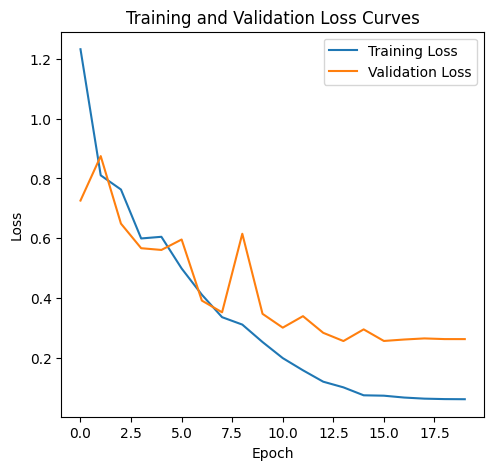

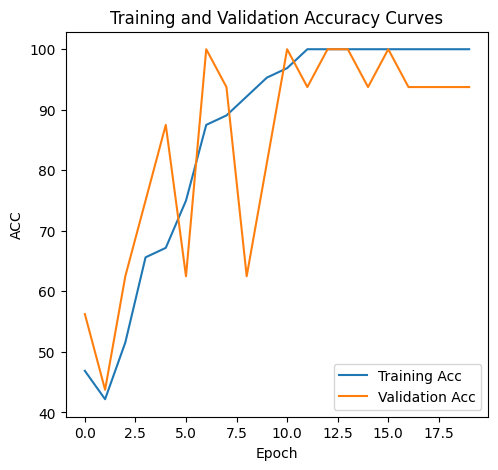

In [22]:
def main():
    seed_everything(config.seed)
    
    df = pd.read_csv(os.path.join(config.root, "train.csv"))
    
    # split training & validation dataset 
    n = df.shape[0]
    valid_size = int(n * config.valid_prob)
    train_ids , valid_ids = train_test_split(
     np.linspace(0, n - 1, n).astype("int"),
     test_size = valid_size,
     random_state = config.seed,
    )
    
    print("Initializing dataset...")  
    train_df = df.iloc[train_ids]
    valid_df = df.iloc[valid_ids]
    train_dataset = MRI2DDataset(train_df, mode = "train",transforms = build_transform(True))
    valid_dataset = MRI2DDataset(valid_df, mode = "valid",transforms = build_transform(False))

    
    # DataLoader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)
    
    
    # settings
    print("Initializing model...")
    num_classes = 2
    print('num_classes',num_classes)
    model_Single = Single_slice(num_classes = num_classes, features_grad = True)
    model_Single.to(config.device)

    # 散則適當的criterion, optimizer
    criterion = nn.CrossEntropyLoss().to(config.device)
    optimizer = torch.optim.AdamW(model_Single.parameters(), lr = config.lr, weight_decay = config.weight_decay)
    # 以 batch 為單位來更新學習率
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = config.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = config.lr,
        anneal_strategy = 'cos'
    )

    # recordings
    best_val_loss = float("inf")
    early_stop_count = 0
    early_stop_threshold = 15
    history = {
      "train": {
          "loss": [],
          "acc": [],
          "f1": []
      },
      "valid": {
          "loss": [],
          "acc": [],
          "f1": []
      },
    }

    print("Start training!")
    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model_Single, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1 = validation(model_Single, valid_loader, criterion, config.device)

        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        if valid_loss < best_val_loss:
            save_file = {
                "model": model_Single.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint_Single.pth")
            early_stop_count = 0  # reset early stopping counter
        else:
            early_stop_count += 1

        if early_stop_count >= early_stop_threshold:
            print(f"Early stopping at epoch {epoch+1}")
            break

    best_ckpt = torch.load("checkpoint_Single.pth", map_location=config.device)
    model_Single.load_state_dict(best_ckpt["model"])
    
    valid_loss, valid_acc, valid_f1 = validation(model_Single, valid_loader, criterion, config.device)
    print("*"*10, " Validation ", "*"*10)
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%")
    
    del train_loader
    del valid_loader
    del train_dataset
    del valid_dataset
    gc.collect()
    # 用於釋放 CUDA GPU 的顯存
    torch.cuda.empty_cache()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(history["train"]["loss"])), history["train"]["loss"], label='Training Loss')
    plt.plot(range(len(history["valid"]["loss"])), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(history["train"]["acc"])), history["train"]["acc"], label='Training Acc')
    plt.plot(range(len(history["valid"]["acc"])), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('ACC')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(history["train"]["f1"])), history["train"]["f1"], label='Training F1')
    plt.plot(range(len(history["valid"]["f1"])), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()

if __name__ == "__main__":
    main()

In [23]:
seed_everything(config.seed)
test_df = pd.read_csv(os.path.join(config.root, "test.csv"))

test_dataset = MRI2DDataset(test_df, mode = "test",transforms = build_transform(False))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
model_Single = Single_slice(num_classes = 2, features_grad = True)

model_Single.to("cuda")

best_ckpt = torch.load(f"checkpoint_Single.pth")
model_Single.load_state_dict(best_ckpt["model"])

preds = testing(model_Single, test_loader, config.device)
del test_dataset
gc.collect()
torch.cuda.empty_cache()

100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


In [24]:
results_df = pd.read_csv(os.path.join(config.root, "submission.csv"))
results_df['Disease'] = preds.cpu().numpy() 
results_df.to_csv("single.csv", index=False)